# DQN (train)
https://simoninithomas.github.io/Deep_reinforcement_learning_Course/  
https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8  
https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682  
https://github.com/yandexdataschool/Practical_RL/blob/master/week4_approx_rl/homework_pytorch.ipynb  
http://maciejjaskowski.github.io/2016/03/09/space-invaders.html  
https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

## 1. Setup

In [1]:
import config
import gym
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from collections import deque
from dqn import DQN
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
skimage.version: 0.14.1
tf.version: 1.11.0


## 2. Look at our env

In [2]:
env = gym.make(config.GAME_NAME)
state = env.reset()
print(f'Game: {config.GAME_NAME}')
print('A state (in env, not in our dqn) is represented by a frame')
print(type(state), state.dtype)
print(state.shape)

Game: Pong-v0
A state (in env, not in our dqn) is represented by a frame
<class 'numpy.ndarray'> uint8
(210, 160, 3)


In [3]:
print(f'Num_Actions: {env.action_space.n}')
action_meanings = env.unwrapped.get_action_meanings()
for i in range(env.action_space.n):
    print(f'{i}: {action_meanings[i]}')

Num_Actions: 6
0: NOOP
1: FIRE
2: RIGHT
3: LEFT
4: RIGHTFIRE
5: LEFTFIRE


__Look how the rgb frame is preprocessed__

initial: uint8
preprocessed_frame: uint8, [62, 236]


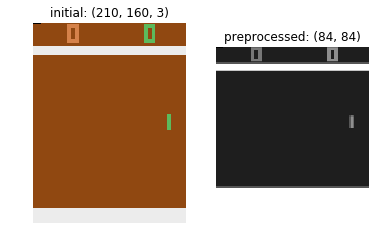

In [4]:
env.reset()
rgb_frame, _, _, _ = env.step(1)
preprocessed_frame = preprocess_frame(rgb_frame)

print(f'initial: {rgb_frame.dtype}')
print(f'preprocessed_frame: {preprocessed_frame.dtype}'
      f', [{preprocessed_frame.min()}, {preprocessed_frame.max()}]')

plt.figure()

plt.subplot(1, 2, 1)
plt.title(f'initial: {rgb_frame.shape}')
plt.axis('off')
plt.imshow(rgb_frame)

plt.subplot(1, 2, 2)
plt.title(f'preprocessed: {preprocessed_frame.shape}')
plt.axis('off')
plt.imshow(preprocessed_frame, cmap='gray')

plt.show()

## 3. DQN

### CNN architecture
1. Conv2d(filters=32, kernel_size=8, strides=4, padding='valid', activation=ReLU)
2. Conv2d(filters=64, kernel_size=4, strides=2, padding='valid', activation=ReLU)  
2. Conv2d(filters=64, kernel_size=3, strides=1, padding='valid', activation=ReLU) -> Flatten()  
3. FC(512, activation=ReLU)
4. FC(NUM_ACTIONS, activation=Linear)

### Instantiate DQNs: DQN and TargetDQN

In [5]:
tf.reset_default_graph()

dqn = DQN(action_size=env.action_space.n, dqn_name='DQN')
dqn_target = DQN(action_size=env.action_space.n, dqn_name='DQNTarget')

## 4. Training

### Memory class (for Experience Replay)

In [6]:
class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        indices = np.random.choice(np.arange(buffer_size),
                                   size=batch_size,
                                   replace=False)
        experiences_batch = [self.buffer[idx] for idx in indices]
        return experiences_batch

#### Pre-populate memory by taking random actions and storing each experience (stacked_frames_hwc, action, reward, done)

In [7]:
def get_pre_populated_memory(env):
    memory = Memory(max_size=config.MEMORY_SIZE)
    stacked_frames = None
    
    # start a new episode
    state = env.reset()
    _, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True)

    for _ in range(config.PRETRAIN_LENGTH):            
        # random action
        action = env.action_space.sample() 
        
        # next state
        next_state, reward, done, _ = env.step(action)

        if done:
            # the end of episode (next_state = 0)
            next_state = np.zeros(config.STATE_SHAPE, dtype=np.uint8)
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)

            # add experience to memory
            memory.add((stacked_frames_hwc, action, reward, done))

            # start a new episode
            state = env.reset()
            _, stacked_frames = stack_frames(stacked_frames, state,
                                             is_new_episode=True)
        else:
            # add experience to memory
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
            memory.add((stacked_frames_hwc, action, reward, done))
    
    return memory

### Helper function to copy DQN parameters to DQNTarget

In [8]:
def update_dqn_target():
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQN')
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQNTarget')
    
    op_holder = []
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
        
    return op_holder

### DQN (training algorithm)

In [9]:
def eps_greedy(sess, state, step):
    # eps: exploration probability
    # linear decaying for config.DECAY_STEPS (config.EPS_START ---> config.EPS_END)
    eps = config.EPS_END
    if step <= config.DECAY_STEPS:
        eps = config.EPS_START - step * config.DECAY_STEP_LENGTH
    
    if np.random.rand() < eps:
        # exploration with eps probability
        action = env.action_space.sample()
    else:
        # exploitation with (1 - eps) probability
        Q = sess.run(dqn.output,
                     feed_dict={
                         dqn.input_ph: state[np.newaxis]
                     })
        
        action = np.argmax(Q)

    return action, eps

In [10]:
def dqn_training(dqn, dqn_target):
    
    # memory for experience replay
    memory = get_pre_populated_memory(env)
    
    # update dqn target op
    update_dqn_target_op = update_dqn_target()    
    
    # to save some ckpts
    saver = tf.train.Saver(max_to_keep=30)
    
    with tf.Session() as sess:
        # init tf variables
        sess.run(tf.global_variables_initializer())
        
        # init dqn_target with the same params as dqn
        sess.run(update_dqn_target_op)
        
        step = 0
        iters_per_episode = []
        reward_per_episode = []
        loss_per_iter = []
        
        for episode in range(1, config.NUM_EPISODES + 1):
            episode_step = 0
            done = False
            stacked_frames = None
            episode_rewards = []
            
            # new episode
            state = env.reset()
            stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, state,
                                                              is_new_episode=True)
            
            while not done:
                episode_step += 1
                step += 1
                
                # eps-gredy
                current_state = stacked_frames_hwc[:,:,-config.STACK_SIZE:]
                action, eps = eps_greedy(sess, current_state, step)
                
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                
                if done:
                    # the end of episode (next_state = 0)
                    next_state = np.zeros(config.STATE_SHAPE, dtype=np.uint8)
                    stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                                      is_new_episode=False)
                    # add experience to memory
                    memory.add((stacked_frames_hwc, action, reward, done))
                    
                    total_reward = np.sum(episode_rewards)
                    reward_per_episode.append(total_reward)
                    iters_per_episode.append(episode_step)
                    
                    print(f'Episode: {episode}, '
                          f'Total reward: {total_reward}, '
                          f'Epsilon: {eps:.5f}, '
                          f'Episode steps: {episode_step}\n'
                          f'Total training steps after {episode} episodes: {step}')
                else:
                    stacked_frames_hwc, stacked_frames = stack_frames(stacked_frames, next_state,
                                                                      is_new_episode=False)
                    # add experience to memory
                    memory.add((stacked_frames_hwc, action, reward, done))

                ### learning part ###
                # sample a random batch of experiences from memory
                batch = memory.sample(config.BATCH_SIZE)
                batch_states = np.array([experience[0][:,:,:-1] for experience in batch]) / 255.
                batch_next_states = np.array([experience[0][:,:,1:] for experience in batch]) / 255.
                batch_actions = np.array([experience[1] for experience in batch])
                batch_rewards = np.array([experience[2] for experience in batch])
                batch_dones = np.array([experience[3] for experience in batch])
                
                # if the episode ends at next_state:
                #     Q_target(state) = reward
                # else:
                #     Q_target(state) = reward + gamma * max(a){Q_next_state}
                Q_batch_next_state = sess.run(dqn_target.output,
                                              feed_dict={
                                                  dqn_target.input_ph: batch_next_states
                                              })
                
                # terminal states => Q value = 0
                Q_batch_next_state[batch_dones, :] = 0
                
                Q_target = batch_rewards + config.GAMMA * np.max(Q_batch_next_state, axis=1)
                
                loss, _ = sess.run([dqn.loss, dqn.optimization_step],
                                   feed_dict={
                                       dqn.input_ph: batch_states,
                                       dqn.actions_ph: batch_actions,
                                       dqn.Q_target_ph: Q_target,
                                   })
                
                loss_per_iter.append(loss)
                
                if step % config.Q_TARGET_UPDATE_FREQ == 0:
                    print('Update parameters of DQNTarget')
                    sess.run(update_dqn_target_op)
                
            if (episode in [1, config.NUM_EPISODES]) or (episode % config.SAVE_EVERY == 0):
                saver.save(sess, f'{config.SAVE_PATH}/model_episode_{episode}.ckpt')
                print('Model saved')
                
    return iters_per_episode, reward_per_episode, loss_per_iter

In [11]:
%%time
!rm -rf $config.SAVE_PATH
train_stats = dqn_training(dqn, dqn_target)

Episode: 1, Total reward: -20.0, Epsilon: 0.97624, Episode steps: 1200
Total training steps after 1 episodes: 1200
Model saved
Episode: 2, Total reward: -21.0, Epsilon: 0.94894, Episode steps: 1379
Total training steps after 2 episodes: 2579
Episode: 3, Total reward: -21.0, Epsilon: 0.92656, Episode steps: 1130
Total training steps after 3 episodes: 3709
Episode: 4, Total reward: -18.0, Epsilon: 0.89781, Episode steps: 1452
Total training steps after 4 episodes: 5161
Episode: 5, Total reward: -20.0, Epsilon: 0.87292, Episode steps: 1257
Total training steps after 5 episodes: 6418
Model saved
CPU times: user 4min 38s, sys: 4min 42s, total: 9min 20s
Wall time: 3min 6s


#### Training stats

In [12]:
iters_per_episode, reward_per_episode, loss_per_iter = train_stats

#### Some plots

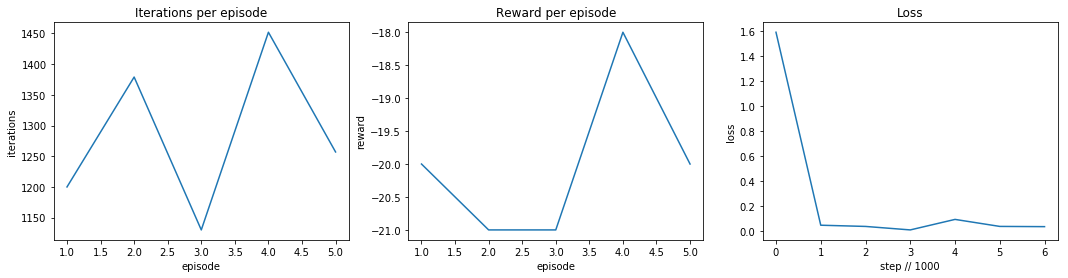

In [13]:
episode_range = np.arange(len(iters_per_episode)) + 1
iter_range = np.arange(len(loss_per_iter)) + 1

plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(1, 3, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')

plt.subplot(1, 3, 3)
plt.title('Loss')
plt.plot(iter_range[::1000] // 1000, loss_per_iter[::1000])
plt.ylabel('loss')
plt.xlabel('step // 1000')
plt.show()